# Using TensorFlow for Stylenet/NeuralStyle
---------------------------------------

We use two images, a content image and a style image and try to make the content image in the style of the style image.

Reference paper:
https://arxiv.org/abs/1508.06576

We will use the pretrained model 'VGG-19' on image-net from `tf.keras.applications.VGG19`

This recipe is an adapted version of the official TensorFlow [Neural style transfer tutorial](https://www.tensorflow.org/tutorials/generative/style_transfer)

We start by loading the necessary libraries.

In [1]:
import imageio
import numpy as np
from skimage.transform import resize
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as display
import PIL.Image

Load image files and set algorithm parameters and weights.

*Note: You may have to change the file locations to where you downloaded the files.*

In [2]:
# To execute if the code is executed on Collab
from google.colab import drive
drive.mount('/content/drive')

path = 'drive/My Drive/08-Book/TF2_ML_CookBook_Packt/tensorflow_cookbook-master/08_Convolutional_Neural_Networks/'

Mounted at /content/drive


In [3]:
# Image Files
# path = ''
content_image_file = path + 'images/book_cover.jpg'
style_image_file = path + 'images/starry_night.jpg'

Read the content and style images and change the style image to fit the content image dimensions

In [4]:
# Read the images
content_image = imageio.imread(content_image_file)
style_image = imageio.imread(style_image_file)
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = tf.image.convert_image_dtype(style_image, tf.float32)

# Get shape of target and make the style image the same
target_shape = content_image.shape
style_image = resize(style_image, target_shape)

Display the content and style images

Text(0.5, 1.0, 'Style Image')

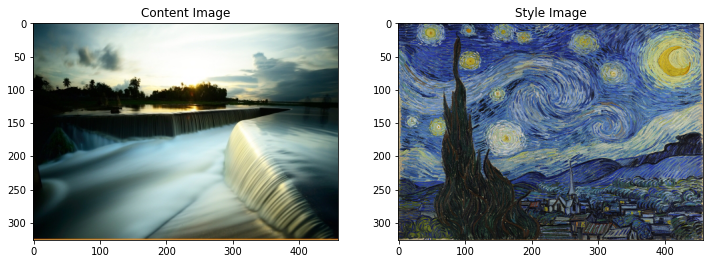

In [ ]:
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title("Content Image")

plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title("Style Image")

We will load the VGG-19 model pre-trained on imagenet without the classification head. We will use the `tensorflow.keras.applications` API. 

*This API contains pre-trained deep learning models that can be used for prediction, feature extraction and fine-tuning.*

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

80142336/80134624 [==============================] - 1s 0us/step


Display the VGG19 architecture

In [ ]:
[layer.name for layer in vgg.layers]

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In neural style transfer, we want to apply the style of one image to the content of another image.

A CNN is composed of several convolutional and pooling layers.
The convolutional layers extract complex features and the pooling layers give spatial information.

The paper recommends a few strategies for assigning intermediate layers to the content and style images. While we should keep block4_conv2 for the content image, we can try different combinations of the other blockX_conv1 layer outputs for the style image.

In [ ]:
content_layers = ['block4_conv2', 'block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

While the values of the intermediate feature maps represent the content of an image, the style can be described by the means and correlations across these feature maps. 

Here, we define the gram matrix to capture the style of an image. This computation is done on each intermediate feature maps and get only information about the texture of an image. Note that we lose information about its spatial structure.


In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

We build a model that returns style and content dictionnaries which contain the name of each layer and associated content/style tensors.
The gram matrix is applied on the style layers.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()

    self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    self.vgg = tf.keras.Model([vgg.input], outputs)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    inputs = inputs[tf.newaxis, :]
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

Set the style and content targets values. They will be used in the loss computation.

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

While the paper recommends to use LBFGS, we choose Adam optimizer.

In [ ]:
#Optimizer configuration
learning_rate = 0.05
beta1 = 0.9
beta2 = 0.999

opt = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2)

We compute the total loss as a weighted sum of the content and the style losses.

In [ ]:
content_weight = 50.0
style_weight = 1.0

Here we define the loss function as a combined (sum) loss of:

 - Style feature loss: Loss between the style features of our style picture and our current image.
 - Content image loss: Loss between our original image and our current image (through the content layer-features).
 - Total Variation loss:  This loss penalizes sharp change and promotes smoothness in the image.

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

This is a float image so we need to keep the pixel values between 0 and 1.

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Convert a tensor to an image

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

We use gradient tape to run the gradient descent and generate our new image.

....................................................................................................

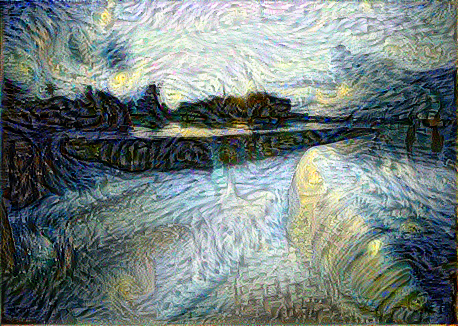

In [ ]:
generations = 100

image = tf.Variable(content_image)

for generation in range(generations):
    
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    print(".", end='')

display.display(tensor_to_image(image))